In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy  as np
import matplotlib
from matplotlib import pylab as plt

#### Import Dataset

In [3]:
df = pd.read_csv('Suicide Rate ML.csv')
print(df.shape)
print(df.columns)

(27820, 8)
Index(['country', 'year', 'sex', 'age', 'population', 'suicides/100k pop',
       'gdp_per_capita ($)', 'generation'],
      dtype='object')


In [4]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

#### Dataset

In [5]:
feature_names = ['country', 'year', 'sex', 'age', 'population','gdp_per_capita ($)', 'generation']
label = 'suicides/100k pop'
y = df[label]
X = df.drop(columns=[label])

#### ML pipeline

Ridge - Lecture 14 <br>
Random Forest Regression - Lecture 18 <br>
SVM rbf Regression - Lecture 19

In [6]:
standard_ftrs = ['population', 'gdp_per_capita ($)']
onehot_ftrs = ['country', 'sex', 'generation']
ordinal_ftrs = ['age']
minmax_ftrs = ['year']

##### Ridge Regression

In [7]:
def ML_pipeline_kfold_ridge(X,y,random_state,n_folds):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state = random_state)
    best_alphas = []
    test_scores = []
    kf = KFold(n_splits=5,shuffle=True,random_state=random_state)
    
    for train_index, CV_index in kf.split(X_other,y_other):
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]
        
        ss = StandardScaler()
        X_train_ss = ss.fit_transform(X_train[standard_ftrs])
        X_train_ss = pd.DataFrame(X_train_ss, columns = standard_ftrs)
        X_c_ss = ss.transform(X_CV[standard_ftrs])
        X_c_ss = pd.DataFrame(X_c_ss, columns = standard_ftrs)
        X_t_ss = ss.transform(X_test[standard_ftrs])
        X_t_ss = pd.DataFrame(X_t_ss, columns = standard_ftrs)
        
        ohe = OneHotEncoder(sparse = False, categories='auto')
        X_train_ohe = ohe.fit_transform(X_train[onehot_ftrs])
        X_train_ohe = pd.DataFrame(X_train_ohe, columns = ohe.get_feature_names())
        X_c_ohe = ohe.transform(X_CV[onehot_ftrs])
        X_c_ohe = pd.DataFrame(X_c_ohe, columns = ohe.get_feature_names())
        X_t_ohe = ohe.transform(X_test[onehot_ftrs])
        X_t_ohe = pd.DataFrame(X_t_ohe, columns = ohe.get_feature_names())
        
        oe = OrdinalEncoder(categories = [['5-14 years','15-24 years', '25-34 years',
                                       '35-54 years','55-74 years','75+ years']])
        X_train_oe = oe.fit_transform(X_train[ordinal_ftrs])
        X_train_oe = pd.DataFrame(X_train_oe, columns = ordinal_ftrs)
        X_c_oe = oe.transform(X_CV[ordinal_ftrs])
        X_c_oe = pd.DataFrame(X_c_oe, columns = ordinal_ftrs)
        X_t_oe = oe.transform(X_test[ordinal_ftrs])
        X_t_oe = pd.DataFrame(X_t_oe, columns = ordinal_ftrs)
        
        mm = MinMaxScaler()
        X_train_mm = mm.fit_transform(X_train[minmax_ftrs])
        X_train_mm = pd.DataFrame(X_train_mm, columns = minmax_ftrs)
        X_c_mm = mm.transform(X_CV[minmax_ftrs])
        X_c_mm = pd.DataFrame(X_c_mm, columns = minmax_ftrs)
        X_t_mm = mm.transform(X_test[minmax_ftrs])
        X_t_mm = pd.DataFrame(X_t_mm, columns = minmax_ftrs)

        X_train_ = pd.concat([X_train_mm, X_train_oe, X_train_ohe, X_train_ss], axis=1)
        X_CV_ = pd.concat([X_c_mm, X_c_oe, X_c_ohe, X_c_ss], axis=1)
        X_test_ = pd.concat([X_t_mm, X_t_oe, X_t_ohe, X_t_ss], axis=1)
        
        alpha = np.logspace(-16,1,100)
        CV_score = []
        regs = []
        for a in alpha:
            reg = Ridge(alpha = a)
            reg.fit(X_train_, y_train)
            CV_score.append(reg.score(X_CV_, y_CV))
            regs.append(reg)
            
        best_alpha = alpha[np.argmax(CV_score)]
        best_alphas.append(best_alpha)
        
        reg = regs[np.argmax(CV_score)]
        test_scores.append(reg.score(X_test_,y_test))
        
    BA = best_alphas[np.argmax(test_scores)]
    return BA, test_scores

In [8]:
TS_ridge = []
for i in range(10):
    best_alpha, test_score = ML_pipeline_kfold_ridge(X, y, 42*i, 5)
    TS_ridge.append(test_score)
    print('Random state = {} and best alpha = {}.'.format(42*i, best_alpha))
print('test accuracy score:', np.around(np.mean(TS_ridge),3), '+/-', np.around(np.std(TS_ridge),3))

Random state = 0 and best alpha = 10.0.
Random state = 42 and best alpha = 2.056512308348643.
Random state = 84 and best alpha = 10.0.
Random state = 126 and best alpha = 6.734150657750801.
Random state = 168 and best alpha = 8.302175681319735e-14.
Random state = 210 and best alpha = 3.0538555088334123.
Random state = 252 and best alpha = 4.534878508128592.
Random state = 294 and best alpha = 2.205130739903041e-16.
Random state = 336 and best alpha = 0.2848035868435793.
Random state = 378 and best alpha = 1e-16.
test accuracy score: 0.509 +/- 0.009


##### Random Forest

In [9]:
def ML_pipeline_kfold_rf(X, y, random_state, n_folds):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state = random_state)
    best_ds = []
    test_scores = []
    kf = KFold(n_splits=5,shuffle=True,random_state=random_state)
    
    for train_index, CV_index in kf.split(X_other, y_other):
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]
        
        ss = StandardScaler()
        X_train_ss = ss.fit_transform(X_train[standard_ftrs])
        X_train_ss = pd.DataFrame(X_train_ss, columns = standard_ftrs)
        X_c_ss = ss.transform(X_CV[standard_ftrs])
        X_c_ss = pd.DataFrame(X_c_ss, columns = standard_ftrs)
        X_t_ss = ss.transform(X_test[standard_ftrs])
        X_t_ss = pd.DataFrame(X_t_ss, columns = standard_ftrs)
        
        ohe = OneHotEncoder(sparse = False, categories='auto')
        X_train_ohe = ohe.fit_transform(X_train[onehot_ftrs])
        X_train_ohe = pd.DataFrame(X_train_ohe, columns = ohe.get_feature_names())
        X_c_ohe = ohe.transform(X_CV[onehot_ftrs])
        X_c_ohe = pd.DataFrame(X_c_ohe, columns = ohe.get_feature_names())
        X_t_ohe = ohe.transform(X_test[onehot_ftrs])
        X_t_ohe = pd.DataFrame(X_t_ohe, columns = ohe.get_feature_names())
        
        oe = OrdinalEncoder(categories = [['5-14 years','15-24 years', '25-34 years',
                                       '35-54 years','55-74 years','75+ years']])
        X_train_oe = oe.fit_transform(X_train[ordinal_ftrs])
        X_train_oe = pd.DataFrame(X_train_oe, columns = ordinal_ftrs)
        X_c_oe = oe.transform(X_CV[ordinal_ftrs])
        X_c_oe = pd.DataFrame(X_c_oe, columns = ordinal_ftrs)
        X_t_oe = oe.transform(X_test[ordinal_ftrs])
        X_t_oe = pd.DataFrame(X_t_oe, columns = ordinal_ftrs)
        
        mm = MinMaxScaler()
        X_train_mm = mm.fit_transform(X_train[minmax_ftrs])
        X_train_mm = pd.DataFrame(X_train_mm, columns = minmax_ftrs)
        X_c_mm = mm.transform(X_CV[minmax_ftrs])
        X_c_mm = pd.DataFrame(X_c_mm, columns = minmax_ftrs)
        X_t_mm = mm.transform(X_test[minmax_ftrs])
        X_t_mm = pd.DataFrame(X_t_mm, columns = minmax_ftrs)

        X_train_ = pd.concat([X_train_mm, X_train_oe, X_train_ohe, X_train_ss], axis=1)
        X_CV_ = pd.concat([X_c_mm, X_c_oe, X_c_ohe, X_c_ss], axis=1)
        X_test_ = pd.concat([X_t_mm, X_t_oe, X_t_ohe, X_t_ss], axis=1)
        
        depths = [depth for depth in range(7,16)]
        splits = [split for split in range(3,12)]
        ds = [(depth, split) for depth in depths for split in splits]
        CV_score = []
        clfs = []
        for d, s in ds:
            clf = RandomForestRegressor(n_estimators=100, random_state=random_state,
                                         max_depth=d, min_samples_split=s)
            clf.fit(X_train_, y_train)
            CV_score.append(clf.score(X_CV_, y_CV))
            clfs.append(clf)
        best_d = ds[np.argmax(CV_score)][0]
        best_s = ds[np.argmax(CV_score)][1]
        best_ds.append((best_d, best_s))
        clf = clfs[np.argmax(CV_score)]
        test_scores.append(clf.score(X_test_,y_test))
    DS = best_ds[np.argmax(test_scores)]
    return DS, test_scores

In [10]:
TS_rf = []
for i in range(10):
    best_ds, test_score = ML_pipeline_kfold_rf(X, y, 42*i,5)
    TS_rf.append(test_score)
    print('Random state = {}, best max_depth = {}, and best min_samples_split = {}.'.format(42*i,
                                                                                             best_ds[0], best_ds[1]))
print('test accuracy score:', np.around(np.mean(TS_rf),3), '+/-', np.around(np.std(TS_rf),3))

Random state = 0, best max_depth = 15, and best min_samples_split = 5.
Random state = 42, best max_depth = 15, and best min_samples_split = 3.
Random state = 84, best max_depth = 15, and best min_samples_split = 3.
Random state = 126, best max_depth = 15, and best min_samples_split = 5.
Random state = 168, best max_depth = 15, and best min_samples_split = 3.
Random state = 210, best max_depth = 15, and best min_samples_split = 6.
Random state = 252, best max_depth = 15, and best min_samples_split = 4.
Random state = 294, best max_depth = 15, and best min_samples_split = 4.
Random state = 336, best max_depth = 15, and best min_samples_split = 4.
Random state = 378, best max_depth = 15, and best min_samples_split = 4.
test accuracy score: 0.742 +/- 0.015


##### SVR

In [7]:
def ML_pipeline_kfold_svr(X, y, random_state, n_folds):
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, 
                                                        random_state = random_state)
    best_gc = []
    test_scores = []
    kf = KFold(n_splits=5,shuffle=True,random_state=random_state) 
    
    for train_index, CV_index in kf.split(X_other, y_other):
        X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
        y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]
        
        ss = StandardScaler()
        X_train_ss = ss.fit_transform(X_train[standard_ftrs])
        X_train_ss = pd.DataFrame(X_train_ss, columns = standard_ftrs)
        X_c_ss = ss.transform(X_CV[standard_ftrs])
        X_c_ss = pd.DataFrame(X_c_ss, columns = standard_ftrs)
        X_t_ss = ss.transform(X_test[standard_ftrs])
        X_t_ss = pd.DataFrame(X_t_ss, columns = standard_ftrs)
        
        ohe = OneHotEncoder(sparse = False, categories='auto')
        X_train_ohe = ohe.fit_transform(X_train[onehot_ftrs])
        X_train_ohe = pd.DataFrame(X_train_ohe, columns = ohe.get_feature_names())
        X_c_ohe = ohe.transform(X_CV[onehot_ftrs])
        X_c_ohe = pd.DataFrame(X_c_ohe, columns = ohe.get_feature_names())
        X_t_ohe = ohe.transform(X_test[onehot_ftrs])
        X_t_ohe = pd.DataFrame(X_t_ohe, columns = ohe.get_feature_names())
        
        oe = OrdinalEncoder(categories = [['5-14 years','15-24 years', '25-34 years',
                                       '35-54 years','55-74 years','75+ years']])
        X_train_oe = oe.fit_transform(X_train[ordinal_ftrs])
        X_train_oe = pd.DataFrame(X_train_oe, columns = ordinal_ftrs)
        X_c_oe = oe.transform(X_CV[ordinal_ftrs])
        X_c_oe = pd.DataFrame(X_c_oe, columns = ordinal_ftrs)
        X_t_oe = oe.transform(X_test[ordinal_ftrs])
        X_t_oe = pd.DataFrame(X_t_oe, columns = ordinal_ftrs)
        
        mm = MinMaxScaler()
        X_train_mm = mm.fit_transform(X_train[minmax_ftrs])
        X_train_mm = pd.DataFrame(X_train_mm, columns = minmax_ftrs)
        X_c_mm = mm.transform(X_CV[minmax_ftrs])
        X_c_mm = pd.DataFrame(X_c_mm, columns = minmax_ftrs)
        X_t_mm = mm.transform(X_test[minmax_ftrs])
        X_t_mm = pd.DataFrame(X_t_mm, columns = minmax_ftrs)

        X_train_ = pd.concat([X_train_mm, X_train_oe, X_train_ohe, X_train_ss], axis=1)
        X_CV_ = pd.concat([X_c_mm, X_c_oe, X_c_ohe, X_c_ss], axis=1)
        X_test_ = pd.concat([X_t_mm, X_t_oe, X_t_ohe, X_t_ss], axis=1)
        
        
        
        cs = np.logspace(-3, 10, 13)
        gammas = np.logspace(-9, 3, 13)
        gc = [(gamma, c) for gamma in gammas for c in cs]
        CV_score = []
        clfs = []
        for g, c in gc:
            clf = SVR(gamma=g, C=c)
            clf.fit(X_train_, y_train)
            CV_score.append(clf.score(X_CV_, y_CV))
            clfs.append(clf)
        best_g = gc[np.argmax(CV_score)][0]
        best_c = gc[np.argmax(CV_score)][1]
        best_gc.append((best_g, best_c))
        clf = clfs[np.argmax(CV_score)]
    test_scores.append(clf.score(X_test_,y_test))
    GC = best_gc[np.argmax(test_scores)]
    return GC, test_scores
    

In [ ]:
TS_svr = []
for i in range(10):
    best_gc, test_score = ML_pipeline_kfold_svr(X, y, 42*i, 5)
    TS_svr.append(test_score)
    print('Random state = {}, best gamma = {}, and best C = {}.'.format(42*i, 
                                                                         best_gc[0], best_gc[1]))

print('test accuracy score:', np.around(np.mean(TS_svr),3), '+/-', np.around(np.std(TS_svr),3))

#### Feature Importance

##### Random Forest

[2.61832185e-02 2.48164388e-01 1.52653787e-06 7.95027135e-05
 6.90990483e-05 6.02917741e-06 1.14422563e-03 6.84464505e-05
 1.32475768e-02 4.22135423e-08 4.42677838e-05 2.36254524e-06
 2.26071285e-05 2.25226301e-02 1.25659279e-03 2.91766437e-04
 0.00000000e+00 9.06822359e-06 8.59215420e-03 5.32901646e-06
 1.77858805e-05 1.12352205e-04 2.17534035e-04 8.17314679e-07
 8.24848918e-03 1.20523545e-02 2.89014882e-06 2.07983234e-03
 2.01811896e-05 0.00000000e+00 1.69940438e-04 9.26504856e-05
 1.17096758e-02 1.11557416e-04 8.75845813e-03 8.88136206e-03
 4.49211468e-06 1.57973460e-04 7.91091054e-05 5.03018144e-05
 1.63310573e-06 1.02813526e-02 3.57651644e-02 1.25998147e-03
 2.20083481e-04 1.02475404e-04 1.15708594e-05 4.92152076e-07
 2.23753499e-03 2.18256694e-02 3.39307114e-04 5.55648650e-05
 4.71154366e-04 2.00925916e-02 4.74348832e-02 4.85927272e-03
 8.26092445e-04 4.18163191e-04 1.29354041e-04 5.91948394e-04
 4.07993465e-06 0.00000000e+00 1.30099569e-03 1.18525269e-05
 2.02421977e-03 8.375075

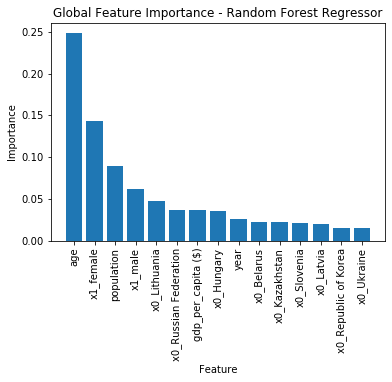

[3.48480210e-02 2.48957680e-01 2.14576447e-09 1.00996432e-04
 2.00055279e-05 5.83756032e-06 1.93416395e-03 9.42627513e-05
 1.20656806e-02 1.63854311e-07 5.69924596e-05 2.10446771e-05
 8.73855551e-05 2.25626204e-02 1.38608299e-03 2.93969057e-04
 0.00000000e+00 3.24662737e-05 1.29008609e-02 3.56995187e-05
 1.11462207e-05 1.95604955e-05 1.02889502e-04 4.74520066e-05
 4.49415940e-03 1.32054593e-02 5.85760650e-05 1.09207331e-04
 2.69515430e-06 0.00000000e+00 6.87137467e-06 1.71215064e-04
 1.48157414e-02 1.18504479e-04 1.05170964e-02 6.63121196e-03
 2.08577913e-10 2.88636174e-04 1.52700246e-04 5.19018352e-05
 2.32172131e-06 1.12281880e-02 3.33664395e-02 1.33561602e-03
 3.69595464e-04 4.36595851e-05 1.28848345e-05 1.62351824e-08
 1.90548286e-03 2.03960151e-02 3.01895615e-04 6.20725356e-05
 2.13373463e-04 2.15928786e-02 4.88269237e-02 5.64431425e-03
 8.24900160e-04 2.48978835e-04 2.13986372e-04 4.08744647e-04
 2.46477359e-06 0.00000000e+00 1.99880724e-03 1.32117074e-05
 1.57131368e-03 1.262929

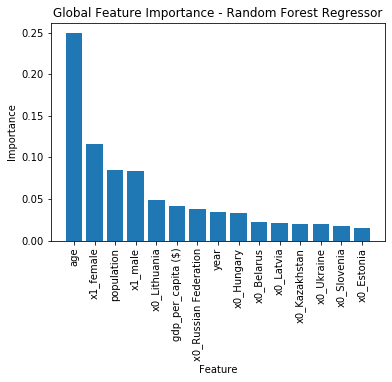

[3.00290305e-02 2.46594459e-01 8.56087756e-07 5.30576744e-05
 5.15065260e-05 1.38774551e-05 2.60540758e-03 2.58586557e-05
 1.39698314e-02 1.70755976e-08 8.12541491e-05 8.65895340e-06
 4.59495421e-05 2.21047063e-02 1.23533780e-03 4.87053876e-04
 0.00000000e+00 3.09166819e-05 9.78613203e-03 3.04178000e-05
 5.80502068e-06 9.81317408e-05 1.96201179e-04 9.09531816e-07
 8.26416608e-03 1.04312724e-02 1.37796203e-06 6.31593172e-04
 7.98970981e-06 0.00000000e+00 1.13641215e-05 1.01000858e-04
 1.73959315e-02 6.87334371e-05 9.42200288e-03 1.06662507e-02
 6.70680266e-07 7.78725651e-05 5.70749787e-05 3.29861991e-05
 3.40291073e-08 1.13264531e-02 4.19759603e-02 1.27287437e-03
 1.06313768e-04 4.72269687e-05 1.14794785e-05 0.00000000e+00
 2.95369555e-03 2.34834524e-02 1.99164133e-04 5.68509984e-05
 1.63592666e-04 1.79435327e-02 4.30598719e-02 5.28165243e-03
 9.08577915e-04 3.45530393e-05 1.05803540e-04 2.16182529e-04
 1.11330823e-05 0.00000000e+00 1.35114478e-03 4.36176389e-06
 1.36792838e-03 6.064289

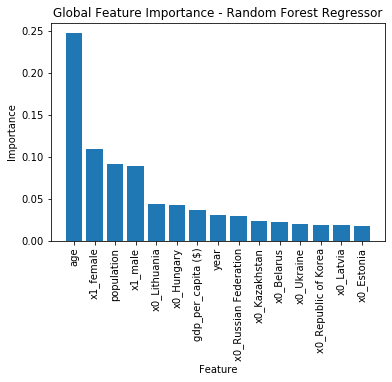

[3.35396696e-02 2.47604568e-01 6.32297828e-06 4.60292016e-05
 3.17863948e-05 2.84320255e-06 1.98334836e-03 6.76241435e-06
 1.21684255e-02 3.11916169e-07 5.28398125e-05 7.40743589e-06
 1.85638219e-05 2.50882215e-02 8.05455600e-04 2.35903069e-04
 0.00000000e+00 8.31872717e-05 9.30453982e-03 7.13764288e-05
 3.52631043e-05 3.48055884e-05 1.61866930e-04 1.42424285e-04
 7.63612306e-03 1.05008585e-02 5.18541280e-05 7.60854809e-04
 1.16421532e-05 0.00000000e+00 2.02373787e-04 1.50521487e-04
 1.23527822e-02 1.28665722e-04 1.09851297e-02 6.63126320e-03
 8.50559884e-09 1.74355152e-04 1.78272378e-04 4.04793146e-05
 5.07181707e-06 1.33622544e-02 3.62567903e-02 1.40145043e-03
 3.90685751e-04 7.47429909e-05 1.26401325e-05 2.98763489e-05
 2.57892198e-03 2.47215250e-02 1.03128469e-04 1.55590168e-05
 2.52812946e-04 1.67954050e-02 3.83814216e-02 5.97704242e-03
 4.45886666e-04 5.49027791e-04 2.13522314e-04 3.67174398e-04
 4.10090267e-06 0.00000000e+00 1.09216617e-03 7.98663621e-06
 1.36315836e-03 4.143781

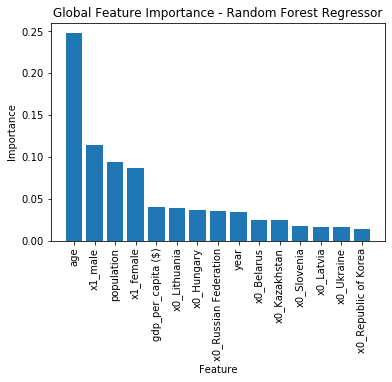

[3.48275424e-02 2.37194123e-01 2.12649253e-06 3.64212027e-05
 3.12755086e-07 1.46323446e-06 2.54175410e-03 6.57906451e-06
 1.01839303e-02 1.93346916e-06 4.19537869e-05 4.10325200e-06
 7.69665712e-05 2.73232603e-02 1.16710218e-03 2.65903912e-04
 0.00000000e+00 4.23584054e-05 1.16546216e-02 4.56286602e-05
 2.15401814e-05 4.64098542e-05 6.21700481e-06 6.56868304e-05
 5.97840910e-03 5.44378305e-03 3.44714465e-05 4.51467093e-04
 7.05847975e-06 0.00000000e+00 1.46405451e-05 1.46698665e-04
 1.34293650e-02 1.07909575e-04 1.11069810e-02 5.59283124e-03
 1.99366366e-08 2.12551338e-04 5.11337416e-05 2.30370973e-05
 3.25656041e-06 1.04785736e-02 4.54082422e-02 7.39809289e-04
 2.48477391e-04 5.81899695e-05 4.50028185e-06 6.14226409e-06
 2.15201596e-03 2.25481442e-02 3.01524068e-04 3.32028348e-05
 3.04647701e-04 2.04957917e-02 4.72323458e-02 4.52920055e-03
 4.67982526e-04 5.07938450e-04 8.23366682e-05 4.45058808e-04
 9.43240985e-07 0.00000000e+00 1.17283024e-03 9.67895994e-06
 1.71927061e-03 7.810114

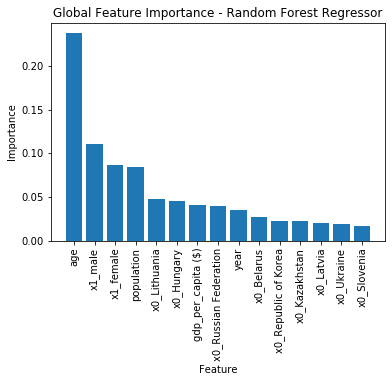

In [8]:
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, random_state = 300)
kf = KFold(n_splits = 5, shuffle = True, random_state = 300)

depths = [15, 15, 15, 15, 15]
splits = [5, 3, 6, 4, 3]
ind = 0
for train_index, CV_index in kf.split(X_other, y_other):
    X_train, X_CV = X_other.iloc[train_index.tolist()], X_other.iloc[CV_index.tolist()]
    y_train, y_CV = y_other.iloc[train_index.tolist()], y_other.iloc[CV_index.tolist()]
    
    ss = StandardScaler()
    X_train_ss = ss.fit_transform(X_train[standard_ftrs])
    X_train_ss = pd.DataFrame(X_train_ss, columns = standard_ftrs)
    X_c_ss = ss.transform(X_CV[standard_ftrs])
    X_c_ss = pd.DataFrame(X_c_ss, columns = standard_ftrs)
    X_t_ss = ss.transform(X_test[standard_ftrs])
    X_t_ss = pd.DataFrame(X_t_ss, columns = standard_ftrs)
        
    ohe = OneHotEncoder(sparse = False, categories='auto')
    X_train_ohe = ohe.fit_transform(X_train[onehot_ftrs])
    X_train_ohe = pd.DataFrame(X_train_ohe, columns = ohe.get_feature_names())
    X_c_ohe = ohe.transform(X_CV[onehot_ftrs])
    X_c_ohe = pd.DataFrame(X_c_ohe, columns = ohe.get_feature_names())
    X_t_ohe = ohe.transform(X_test[onehot_ftrs])
    X_t_ohe = pd.DataFrame(X_t_ohe, columns = ohe.get_feature_names())
        
    oe = OrdinalEncoder(categories = [['5-14 years','15-24 years', '25-34 years',
                                       '35-54 years','55-74 years','75+ years']])
    X_train_oe = oe.fit_transform(X_train[ordinal_ftrs])
    X_train_oe = pd.DataFrame(X_train_oe, columns = ordinal_ftrs)
    X_c_oe = oe.transform(X_CV[ordinal_ftrs])
    X_c_oe = pd.DataFrame(X_c_oe, columns = ordinal_ftrs)
    X_t_oe = oe.transform(X_test[ordinal_ftrs])
    X_t_oe = pd.DataFrame(X_t_oe, columns = ordinal_ftrs)
        
    mm = MinMaxScaler()
    X_train_mm = mm.fit_transform(X_train[minmax_ftrs])
    X_train_mm = pd.DataFrame(X_train_mm, columns = minmax_ftrs)
    X_c_mm = mm.transform(X_CV[minmax_ftrs])
    X_c_mm = pd.DataFrame(X_c_mm, columns = minmax_ftrs)
    X_t_mm = mm.transform(X_test[minmax_ftrs])
    X_t_mm = pd.DataFrame(X_t_mm, columns = minmax_ftrs)

    X_train_ = pd.concat([X_train_mm, X_train_oe, X_train_ohe, X_train_ss], axis=1)
    X_CV_ = pd.concat([X_c_mm, X_c_oe, X_c_ohe, X_c_ss], axis=1)
    X_test_ = pd.concat([X_t_mm, X_t_oe, X_t_ohe, X_t_ss], axis=1)

    clf_rf = RandomForestRegressor(n_estimators=100, random_state=300, 
                                   max_depth=depths[ind], min_samples_split=splits[ind])
    clf_rf.fit(X_train_, y_train)
    imp = clf_rf.feature_importances_
    
    ftrs_df = pd.DataFrame()
    ftrs_df['features'] = X_train_.columns
    ftrs_df['importance'] = imp
    ftrs_df = ftrs_df.sort_values('importance', ascending = False)
    
    print(imp)
    plt.bar(range(15), ftrs_df['importance'][0:15])
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Global Feature Importance - Random Forest Regressor")
    plt.xticks(range(15), ftrs_df['features'][0:15], rotation='vertical')
    plt.savefig('random_forest_global_ftr_importance{}'.format(ind), dpi=500, bbox_inches = "tight")
    plt.show()
    ind += 1